# EDA

The first objective of this assessment is to create a classification model on the data set of text files. To start, I'll do a quick EDA which will guide the model building and likely result in a list of tasks that I'd carry out to make this production quality.

Note, I'll be a bit overly pedantic and go step-by-step for the purpose of illustration. Some of the analysis that follows would likely be combined for a bit more brevity.

In [1]:
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 200)
plt.style.use('bmh')

In [2]:
category_folders = glob("./trellis_assessment_ds/*")
print(f"Number of categories: {len(category_folders):,}")

Number of categories: 11


As expected from the instruction document, there are 11 categories (including "other").

Note, the instructions say the "other" folder should not be used for training and instead is used to "determine if the model can accurately classify
unrecognized documents as 'other'". Thus, there are 10 categories to train on, and I must make sure that if it doesn't fall into those that it gets categorized as "other".

In [3]:
for folder_path in category_folders:
    category = folder_path.split("\\")[-1]
    print(category, len(glob(folder_path + "\\*")))

business 100
entertainment 100
food 100
graphics 100
historical 100
medical 100
other 6
politics 100
space 100
sport 100
technologie 100


No skew in the number of examples except for other that is shockingly few.

Let's see if we actually have a similar amount of data on each of these by creating some stats on the underly text files. As a rough measure, I'll break these documents into word tokens and get some descriptive statistics.

In [37]:
def get_text_file_contents(path: str) -> str: 
    """Read in a text file and return the contents.

    Parameters
    ----------
    path : str
        Input path to a .txt file.
    """
    
    with open(path, "r") as f:
        contents = f.read()
    return contents

# Create a dictionary for each category where the keys are the category
# and the values are a list of the documents.
category_contents = {}
for folder_path in category_folders:
    category = folder_path.split("\\")[-1]
    document_contents = []
    for path in glob(folder_path + "\\*"):
        tokens = get_text_file_contents(path)
        document_contents.append(tokens)
    category_contents[category] = document_contents


In [63]:
# Turn the dictionary of categories:documents into a dataframe.
data = pd.DataFrame.from_dict(category_contents, orient="index").reset_index()
data = (
    pd.melt(data, id_vars="index")
    .rename({"index": "category", "value": "text"}, axis=1)
    .drop("variable", axis=1)
    .dropna()
    .sort_values("category")
    .reset_index() # This is just for the aesthetics of the index aligning with the categories...
    .drop("index", axis=1)
)

data["tokens"] = data["text"].apply(lambda x: x.split())
data["token_count"] = data["tokens"].apply(len)
data["characters"] = data["text"].apply(len)
data["characters_per_token"] = data["characters"] / data["token_count"]

data.head()

,category,text,tokens,token_count,characters,characters_per_token
0,business,"Lufthansa flies back to profit\n\nGerman airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003.\n\nIn a preliminary report, the airline announced net profits of 400m e...","[Lufthansa, flies, back, to, profit, German, airline, Lufthansa, has, returned, to, profit, in, 2004, after, posting, huge, losses, in, 2003., In, a, preliminary, report,, the, airline, announced,...",149,848,5.691275
1,business,"German economy rebounds\n\nGermany's economy, the biggest among the 12 countries sharing the euro, grew at its fastest rate in four years during 2004, driven by strong exports.\n\nGross domestic p...","[German, economy, rebounds, Germany's, economy,, the, biggest, among, the, 12, countries, sharing, the, euro,, grew, at, its, fastest, rate, in, four, years, during, 2004,, driven, by, strong, exp...",222,1377,6.202703
2,business,Weak data buffets French economy\n\nA batch of downbeat government data has cast doubt over the French economy's future prospects.\n\nOfficial figures showed on Friday that unemployment was unchan...,"[Weak, data, buffets, French, economy, A, batch, of, downbeat, government, data, has, cast, doubt, over, the, French, economy's, future, prospects., Official, figures, showed, on, Friday, that, un...",256,1621,6.332031
3,business,Christmas shoppers flock to tills\n\nShops all over the UK reported strong sales on the last Saturday before Christmas with some claiming record-breaking numbers of festive shoppers.\n\nA spokesma...,"[Christmas, shoppers, flock, to, tills, Shops, all, over, the, UK, reported, strong, sales, on, the, last, Saturday, before, Christmas, with, some, claiming, record-breaking, numbers, of, festive,...",374,2187,5.847594
4,business,"Business fears over sluggish EU economy\n\nAs European leaders gather in Rome on Friday to sign the new EU constitution, many companies will be focusing on matters much closer to home - namely how...","[Business, fears, over, sluggish, EU, economy, As, European, leaders, gather, in, Rome, on, Friday, to, sign, the, new, EU, constitution,, many, companies, will, be, focusing, on, matters, much, c...",823,4603,5.592953


In [125]:
# TODO: it would be nice if this wasn't in such a long format. 
# I'd prefer concatenating these horizontally and give it a multi-index column header
for category in data["category"].unique():    
    print(category)
    data.query(f"category == '{category}'").describe().round(2)

business


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,330.26,1974.47,5.99
std,137.13,810.02,0.22
min,147.00,848.00,5.43
25%,248.50,1504.25,5.85
50%,298.00,1816.50,5.98
75%,375.00,2196.00,6.16
max,891.00,5357.00,6.41


entertainment


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,287.02,1690.93,5.91
std,122.22,701.79,0.23
min,152.00,935.00,5.35
25%,215.00,1264.00,5.75
50%,244.50,1457.00,5.92
75%,306.50,1828.25,6.10
max,806.00,4497.00,6.40


food


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,226.47,1438.33,6.45
std,85.22,491.72,0.57
min,94.00,706.00,5.50
25%,163.00,1072.00,6.07
50%,217.50,1431.00,6.35
75%,266.25,1664.00,6.71
max,594.00,3610.00,8.03


graphics


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,310.33,1972.27,6.24
std,808.10,5517.77,0.57
min,21.00,129.00,5.35
25%,103.00,712.50,5.84
50%,192.00,1232.00,6.14
75%,273.50,1718.25,6.44
max,8052.00,55227.00,9.10


historical


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,842.46,5246.99,6.22
std,673.99,4186.08,0.23
min,82.00,507.00,5.62
25%,271.75,1676.75,6.09
50%,704.00,4412.50,6.22
75%,1156.00,7238.50,6.36
max,3082.00,19357.00,6.91


medical


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,435.62,3112.76,6.50
std,940.71,7177.32,0.86
min,30.00,162.00,5.20
25%,115.00,765.00,6.05
50%,163.50,1005.00,6.37
75%,256.00,1596.25,6.77
max,4629.00,35422.00,12.48


other


,token_count,characters,characters_per_token
count,6.00,6.00,6.00
mean,177.17,1103.17,5.78
std,126.79,797.79,0.98
min,19.00,85.00,4.47
25%,71.50,421.50,5.09
50%,227.50,1473.50,5.87
75%,241.75,1600.75,6.42
max,323.00,1873.00,7.03


politics


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,435.00,2584.39,5.97
std,252.91,1455.98,0.21
min,142.00,812.00,5.47
25%,316.75,1843.00,5.84
50%,418.50,2517.00,5.93
75%,503.50,2981.50,6.11
max,2393.00,13829.00,6.63


space


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,465.35,3163.68,6.45
std,713.24,5015.53,0.59
min,19.00,112.00,5.33
25%,94.75,624.00,5.95
50%,190.50,1221.00,6.39
75%,396.50,2486.75,6.83
max,4033.00,25719.00,8.06


sport


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,316.62,1845.64,5.86
std,194.29,1106.61,0.26
min,122.00,743.00,5.23
25%,179.75,1023.00,5.69
50%,255.00,1458.50,5.85
75%,379.50,2179.50,6.04
max,944.00,5104.00,6.61


technologie


,token_count,characters,characters_per_token
count,100.00,100.00,100.00
mean,454.38,2706.23,5.96
std,221.95,1320.13,0.28
min,67.00,437.00,5.30
25%,294.75,1774.00,5.77
50%,433.00,2563.00,5.94
75%,562.25,3377.50,6.16
max,1234.00,7123.00,6.69


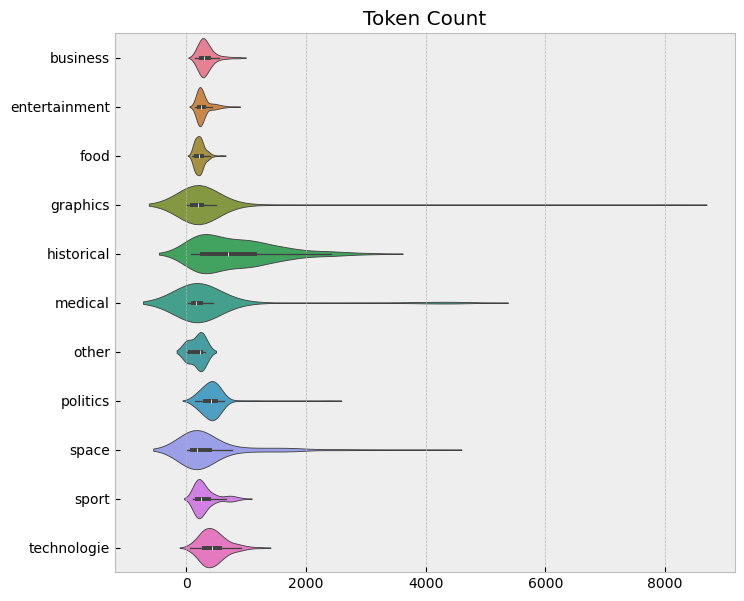

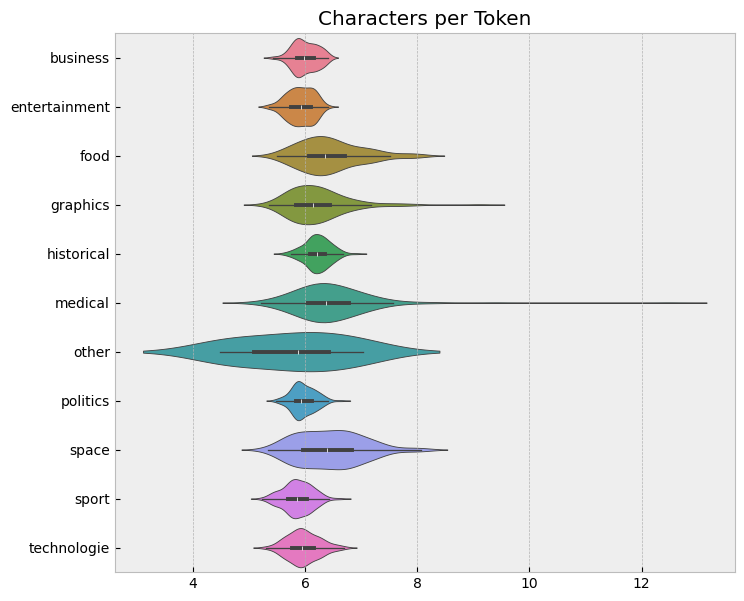

In [124]:
import seaborn

# Getting the raw numbers is good to have, but as currently output its very hard to compare across categories.
# A violin plot will put those numbers into context with each other.
plot_data = {
    category: data.query(f"category == '{category}'")["token_count"].values
    for category in data["category"].unique()
}
fig, ax = plt.subplots(figsize=(8, 7))
_ = seaborn.violinplot(data=plot_data, orient="h", ax=ax).set_title("Token Count")

# Omitting since it looks more or less identical to the above plot.
# plot_data = {
#     category: data.query(f"category == '{category}'")["characters"].values
#     for category in data["category"].unique()
# }
# fig, ax = plt.subplots(figsize=(8, 7))
# _ = seaborn.violinplot(data=plot_data, orient="h", ax=ax).set_title(
#     "Characters"
# )

plot_data = {
    category: data.query(f"category == '{category}'")["characters_per_token"].values
    for category in data["category"].unique()
}
fig, ax = plt.subplots(figsize=(8, 7))
_ = seaborn.violinplot(data=plot_data, orient="h", ax=ax).set_title(
    "Characters per Token"
)

Across categories there is a clear difference in the distribution of tokens. However, some categories are quite similar such as business, entertainment, and food especially if you look at the little box-and-whisker plot embedded in the violin.

Characters per token contains less outliers, but has a bit more unique distributions across the categories. By and large the median is centered around 6ish. The other category is an outlier in shape, but also there are only six examples.

For a starting point, this is sufficient. This shows that there is some difference between the classes. Here are a few options if wanted to do even more EDA:
* Explore details about the contents/vocabulary such as unique words in each category (both qualitatively and quantitatively).
* Length of sentences or paragraphs.
* Use the various NLP tools that assign reading level.
